In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)

import numpy as np
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')


from sklearn import model_selection
from sklearn.model_selection import cross_val_score


from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

import pickle
from sklearn.externals import joblib

%load_ext line_profiler

In [2]:
from app import model

In [3]:
user='gshau'
host='localhost'
dbname='birth_db'

dbname = 'ncaabb'
username = 'gshau' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

years = model.getYears()
year=2017
pointsByRound=[1,2,4,8,16,32]
# pointsByRound=[1,2,4,8,12,16]

In [4]:
# for year in np.arange(2017,2003,-1):
#     t=model.Tournament(year)

#     pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]))
#     pool.getTourneySets(ntourney=1000,scaleFactor=0.579)


In [5]:
# # year=2017
# # t=model.Tournament(year)

# # pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]))
# # pool.getTourneySets(ntourney=100,scaleFactor=0.58)
# # pool.loadTourneySets()
# x=[]
# for ibkt in range(20):
#     tx=pool.tourneys[ibkt]
#     pt=model.compareBrackets(t.bracketOutcome,tx,
#                           pointsByRound=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]))
#     x.append(pt)
# plt.hist(x,bins=range(192));

In [6]:
# %lprun -f pool.simulatePool pool.simulatePool(useRealBracket=False)

In [4]:
def doIt(year=2017,risk=0.3):
    t=model.Tournament(year)
    pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]),risk=risk)
    pool.loadTourneySets()
    print('----', year, '----')
    sim=[]
    simrank=[]
    real=[]
    realrank=[]
    poolList=[]
    for rep in range(20):
    #         print('Simulated bracket: ')
        pool.simulatePool(useRealBracket=False,verbose=False,nrep=20)
#         sim.append(list(pool.payouts))
#         simrank.append(pool.ranks)
        poolList.append(pool)
# #         pool.simulatePool(useRealBracket=True,verbose=False,nrep=20)
# #         real.append(list(pool.payouts))
# #         realrank.append(pool.ranks)
#     print(np.argmax(np.array(sim).sum(axis=1)))
        
#     return (np.array(sim),np.array(simrank),np.array(real),np.array(realrank),poolList)
    return poolList


In [5]:
%time poolList=doIt(year=2008)

Load: Tournament length:  1000
---- 2008 ----
CPU times: user 1.07 s, sys: 28.3 ms, total: 1.1 s
Wall time: 1.11 s


In [13]:
p=poolList[0]
p.summary.keys()
# p.summary['ranks']

dict_keys(['favBracket', 'newBracket', 'expPayout', 'expPlace', 'ranks'])

In [14]:
norm=p.summary['ranks'].sum()
p.summary['ranks'].sum(axis=1)/norm

array([ 0.  ,  0.2 ,  0.05,  0.  ,  0.2 ,  0.1 ,  0.2 ,  0.  ,  0.05,
        0.  ,  0.05,  0.  ,  0.05,  0.05,  0.05,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ])

In [15]:
p.summary['expPlace']

array([[ 0.  ,  0.1 ],
       [ 0.2 ,  0.05],
       [ 0.05,  0.05],
       [ 0.  ,  0.  ],
       [ 0.2 ,  0.1 ],
       [ 0.1 ,  0.1 ],
       [ 0.2 ,  0.  ],
       [ 0.  ,  0.1 ],
       [ 0.05,  0.1 ],
       [ 0.  ,  0.2 ],
       [ 0.05,  0.05],
       [ 0.  ,  0.  ],
       [ 0.05,  0.  ],
       [ 0.05,  0.05],
       [ 0.05,  0.  ],
       [ 0.  ,  0.05],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.05],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ],
       [ 0.  ,  0.  ]])

0.259459459459
0.286486486486
0.464864864865


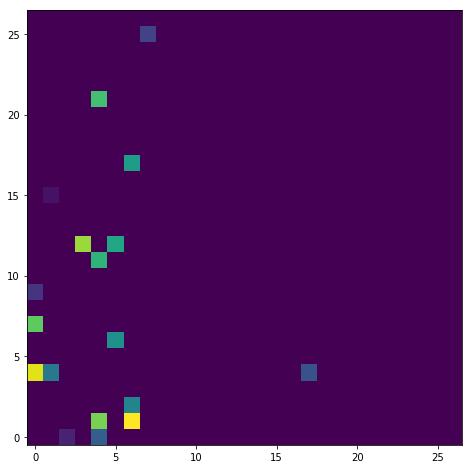

In [162]:
plt.imshow(simrank[13,:,:].T,origin='lower')

norm=simrank[13,:,:].sum()
print(simrank[13,:3,:].sum()/norm)
print(simrank[13,:,:3].sum()/norm)
print(simrank[13,3:,3:].sum()/norm)


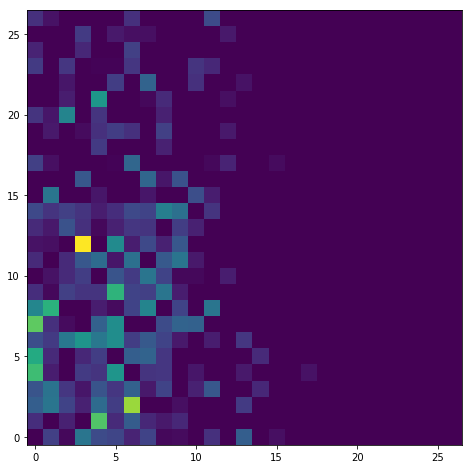

In [156]:
plt.imshow(simrank.sum(axis=0).T,origin='lower')

In [99]:
%lprun -f pool.simulatePool doIt()

Load: Tournament length:  1000
---- 2017 ----


In [24]:
yearList=np.arange(2017,2003,-1)

In [25]:
real={}
sim={}
realrank={}
simrank={}
riskList=[0.2,0.4,0.6,0.8,1.]
# riskList=[0.4]
for risk in riskList:
    real[risk]={}
    sim[risk]={}
    realrank[risk]={}
    simrank[risk]={}
    for year in yearList:
        real[risk][year]=[]
        sim[risk][year]=[]
        realrank[risk][year]=[]
        simrank[risk][year]=[]
        t=model.Tournament(year)
        pool=model.Pool(t,poolSize=25,pointSystem=dict([(i+2, pointsByRound[i]) for i in np.arange(6)]),risk=risk)
        pool.loadTourneySets()
        print('----', year, '----')

        for rep in range(100):
    #         print('Simulated bracket: ')
            pool.simulatePool(useRealBracket=False,verbose=False,nrep=20)
            sim[risk][year].append(list(pool.summary['expPayout']))
            simrank[risk][year].append(pool.summary['ranks'])
    #         print('Real bracket: ')
            pool.simulatePool(useRealBracket=True,verbose=False,nrep=20)
            real[risk][year].append(list(pool.summary['expPayout']))
            realrank[risk][year].append(pool.summary['ranks'])

            

Load: Tournament length:  1000
---- 2017 ----
Load: Tournament length:  1000
---- 2016 ----
Load: Tournament length:  1000
---- 2015 ----
Load: Tournament length:  1000
---- 2014 ----
Load: Tournament length:  1000
---- 2013 ----
Load: Tournament length:  1000
---- 2012 ----
Load: Tournament length:  1000
---- 2011 ----
Load: Tournament length:  1000
---- 2010 ----
Load: Tournament length:  1000
---- 2009 ----
Load: Tournament length:  1000
---- 2008 ----
Load: Tournament length:  1000
---- 2007 ----
Load: Tournament length:  1000
---- 2006 ----
Load: Tournament length:  1000
---- 2005 ----
Load: Tournament length:  1000
---- 2004 ----
Load: Tournament length:  1000
---- 2017 ----
Load: Tournament length:  1000
---- 2016 ----
Load: Tournament length:  1000
---- 2015 ----
Load: Tournament length:  1000
---- 2014 ----
Load: Tournament length:  1000
---- 2013 ----
Load: Tournament length:  1000
---- 2012 ----
Load: Tournament length:  1000
---- 2011 ----
Load: Tournament length:  1000
---

In [22]:
# # riskValue=1.
# # norm=np.array(realrank[riskValue][year]).sum()
# # plt.plot(np.array(realrank[riskValue][year]).sum(axis=0).sum(axis=0)/norm,'b')
# riskValue=0.4
# norm=np.array(realrank[riskValue][year]).sum()
# plt.plot(np.array(realrank[riskValue][year]).sum(axis=0).sum(axis=0)/norm,'r')

In [27]:
riskValue=1
# year=201
bustPct=dict((yr,[]) for yr in yearList)
for year in yearList:
    for riskValue in [0.2,0.4,0.6,0.8,1]:
        norm=np.array(simrank[riskValue][year]).sum(axis=0).sum()
        bustPct[year].append(np.array(simrank[riskValue][year]).sum(axis=0)[3:,3:].sum()/norm)
        
bustPct

{2004: [0.58050000000000002,
  0.55500000000000005,
  0.55100000000000005,
  0.55700000000000005,
  0.55200000000000005],
 2005: [0.53849999999999998,
  0.53049999999999997,
  0.54100000000000004,
  0.53700000000000003,
  0.54500000000000004],
 2006: [0.56000000000000005,
  0.51500000000000001,
  0.52400000000000002,
  0.51449999999999996,
  0.52449999999999997],
 2007: [0.58299999999999996,
  0.55500000000000005,
  0.52600000000000002,
  0.5605,
  0.56100000000000005],
 2008: [0.58999999999999997,
  0.54849999999999999,
  0.55449999999999999,
  0.5595,
  0.58750000000000002],
 2009: [0.61450000000000005,
  0.56000000000000005,
  0.54700000000000004,
  0.58899999999999997,
  0.58750000000000002],
 2010: [0.52049999999999996,
  0.51500000000000001,
  0.4955,
  0.49299999999999999,
  0.505],
 2011: [0.56699999999999995,
  0.53100000000000003,
  0.50649999999999995,
  0.502,
  0.4995],
 2012: [0.51049999999999995,
  0.49099999999999999,
  0.50949999999999995,
  0.51549999999999996,
  0.50

In [35]:
LogisticRegression?

In [34]:
for year in yearList:
    for riskValue in [0.2,0.4,0.6,0.8,1]:
        rankingArray=np.array(realrank[riskValue][year]).sum(axis=0).T
        plt.figure()
        plt.imshow(rankingArray,origin='lower')
        plt.colorbar()
        plt.title('Back-testing '+str(year)+ ', risk = '+str(riskValue))
        plt.xlabel('First bracket ranking')
        plt.ylabel('Second bracket ranking')
        plt.savefig('backtest-'+str(year)+'-r_'+str(riskValue*10).zfill(2)+'.png')
        plt.clf()

In [40]:
np.arange(5,51,5)

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])

In [86]:
year=2017
print(np.array([np.array(real[year])[:,0].mean() for year in yearList]).mean())
print(np.array([np.array(sim[year])[:,0].mean() for year in yearList]).mean())

print(np.array([np.array(real[year])[:,1].mean() for year in yearList]).mean())
print(np.array([np.array(sim[year])[:,1].mean() for year in yearList]).mean())


KeyError: 2017

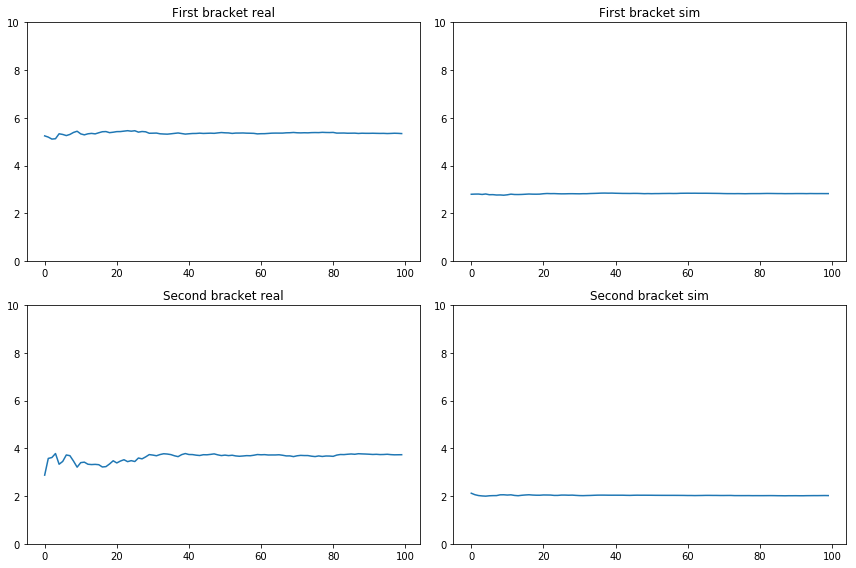

In [47]:
ymax=10

yearList=np.arange(2017,2003,-1)
plt.subplot(2,2,1)
plt.plot(np.array([np.array(real[year])[:,0].cumsum()/(np.arange(len(sim[year]))+1) 
                   for year in yearList]).mean(axis=0))
plt.ylim(0,ymax)
plt.title('First bracket real')

plt.subplot(2,2,2)
plt.plot(np.array([np.array(sim[year])[:,0].cumsum()/(np.arange(len(sim[year]))+1) 
                   for year in yearList]).mean(axis=0))
plt.ylim(0,ymax)
plt.title('First bracket sim')


plt.subplot(2,2,3)
plt.plot(np.array([np.array(real[year])[:,1].cumsum()/(np.arange(len(sim[year]))+1) 
                   for year in yearList]).mean(axis=0))
plt.ylim(0,ymax)
plt.title('Second bracket real')

plt.subplot(2,2,4)
plt.plot(np.array([np.array(sim[year])[:,1].cumsum()/(np.arange(len(sim[year]))+1) 
                   for year in yearList]).mean(axis=0))
plt.ylim(0,ymax)
plt.title('Second bracket sim')
plt.tight_layout()



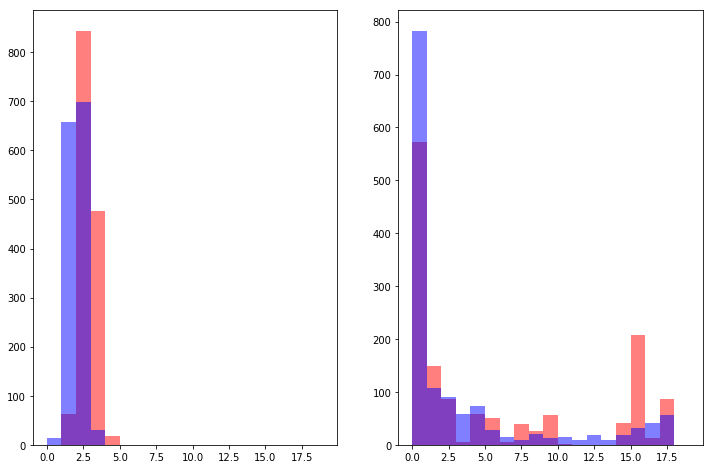

In [36]:
plt.subplot(1,2,1)
plt.hist(np.array([np.array(sim[year])[:,0] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[1,0,0,0.5]);
plt.hist(np.array([np.array(sim[year])[:,1] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[0,0,1,0.5]);
plt.subplot(1,2,2)

plt.hist(np.array([np.array(real[year])[:,0] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[1,0,0,0.5]);
plt.hist(np.array([np.array(real[year])[:,1] for year in np.arange(2017,2003,-1)]).flatten(),bins=range(20),color=[0,0,1,0.5]);

In [23]:
print(np.array([np.array(real[year])[:,0].mean() for year in np.arange(2017,2003,-1)]).mean())
print(np.array([np.array(sim[year])[:,0].mean() for year in np.arange(2017,2003,-1)]).mean())

5.58893571429
2.82238075158


In [24]:
print(np.array([np.array(real[year])[:,1].mean() for year in np.arange(2017,2003,-1)]).mean())
print(np.array([np.array(sim[year])[:,1].mean() for year in np.arange(2017,2003,-1)]).mean())

3.33245
2.02247991328
